## Telegram Behaviour Exploration
#### Author: `ANNA TSVETKOVA`

### Used libraries

In [1]:
%matplotlib inline
%autosave 5

# all imports needed
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.graph_objs import *
from plotly.subplots import make_subplots
import squarify
import seaborn as sns
from string import digits
import re
from collections import Counter
import circlify
import ast
import matplotlib.colors as mcol
import json
from googletrans import Translator
import plotly.express as px
from langdetect import detect
import pymorphy2
from textwrap import wrap
from urllib.parse import urlparse
import networkx as nx

Autosaving every 5 seconds


### Get Data

In [2]:
DIALOGS_MERGED_DATA_PATH = "../data/merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "../data/merged_data/dialogs_users_all.csv"
DIALOGS_ALL_META_MERGED_DATA_PATH = "../data/merged_data/all_meta_data.csv"

In [3]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH, low_memory=False)

#here only dialogs with downloaded messages
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)

#here all dialogs from telegram (even without messages at all)
df_meta_all = pd.read_csv(DIALOGS_ALL_META_MERGED_DATA_PATH)

## Task 5.1 - 5.3
__Find number of symbols written by each person in my private chats.<br>
Find average length of a text message for each person written to my private chats.<br>
Find total lengths of all messages for each person written to my private chats.<br>
And compare all of them.__

In [14]:
privchat = df[(df["to_id"] == "561326466") & (df["type"]=="text") & (df["fwd_from"].isna())]
privchat.head(10)
privchat["lengths"] = [0 for i in range(len(privchat.index))]

for i in set(privchat["dialog_id"].values):
    lengths = []
    temp = privchat[privchat["dialog_id"] == i]
    for index in temp.index:
        privchat.at[index, "lengths"] = len(str(temp.at[index, "message"]).replace("\n", ""))

C:\Users\Anna\AppData\Local\Temp\ipykernel_21668\3592045023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  privchat["lengths"] = [0 for i in range(len(privchat.index))]


In [17]:
# with open('users.txt', "w") as file:
#     file.write(json.dumps(users))
with open('users.txt') as file:
    users = json.loads(file.read())
    
users = dict((int(k), v) for k, v in users.items())

In [18]:
leng_and_n = privchat.groupby(["dialog_id"]).agg({'lengths': 'sum', 'message': 'count'}).sort_values(["message"], ascending=False)[0:100]

leng_and_n["username"] = 0
leng_and_n["average length"] = leng_and_n["lengths"] / leng_and_n["message"]

for i in leng_and_n.index:
    #excluding bots!
    if("bot" in str(users[i]) or "Bot" in str(users[i]) or users[i]=="Stickers" or users[i]=="ymenenema" or users[i]=="Telegram"):
        leng_and_n = leng_and_n.drop(i)
    else:
        leng_and_n.at[i, "username"] = users[i]

leng_and_n = leng_and_n.dropna()

In [19]:
cur21 = leng_and_n[0:15]
cur23 = cur21.sort_values(["lengths"])
cur22 = cur21.sort_values(["average length"])
cur21 = cur21.sort_values(["message"])
cur1 = leng_and_n.sort_values(["average length"], ascending=False)[0:50].sort_values(["average length"])

### So here is the final result: Correlation between number of messages and their average length from user to user.
#### (4 interactive bar sublots with plotly)

In [197]:
cur1 = leng_and_n.sort_values(["average length"], ascending=False)[0:40].sort_values(["average length"])
fig = make_subplots(rows=2, cols=3, specs=[[{}, {}, {}], [{'colspan' :3}, None, None]], subplot_titles=("Top15 Sorted by Message Number", "Top15 Sorted by Average Message Length", "Top15 Sorted by Total Length", "Top40 by Average Message Length"))

fig.add_trace(go.Bar(x=cur21["username"].values, y=cur21["message"].values, marker=dict(color=cur21["average length"].values, coloraxis='coloraxis1')), 1, 1)
fig.add_trace(go.Bar(x=cur22["username"].values, y=cur22["average length"].values, marker=dict(color=cur22["average length"].values, coloraxis='coloraxis1')), 1, 2)
fig.add_trace(go.Bar(x=cur23["username"].values, y=cur23["lengths"].values, marker=dict(color=cur23["average length"].values, coloraxis='coloraxis1')), 1, 3)
fig.add_trace(go.Bar(x=cur1["username"].values, y=cur1["average length"].values, marker=dict(color=cur1["average length"].values, coloraxis='coloraxis2')), 2, 1)

fig.update_layout(
    title_text="Everything about Message Length in my Private Chats",
    title_x=0.5,
    width=1200,
    height=800,
    coloraxis=dict(colorscale='Viridis_r'),
    showlegend =False
)

fig.layout.coloraxis.colorbar.x = -0.12
fig.show()

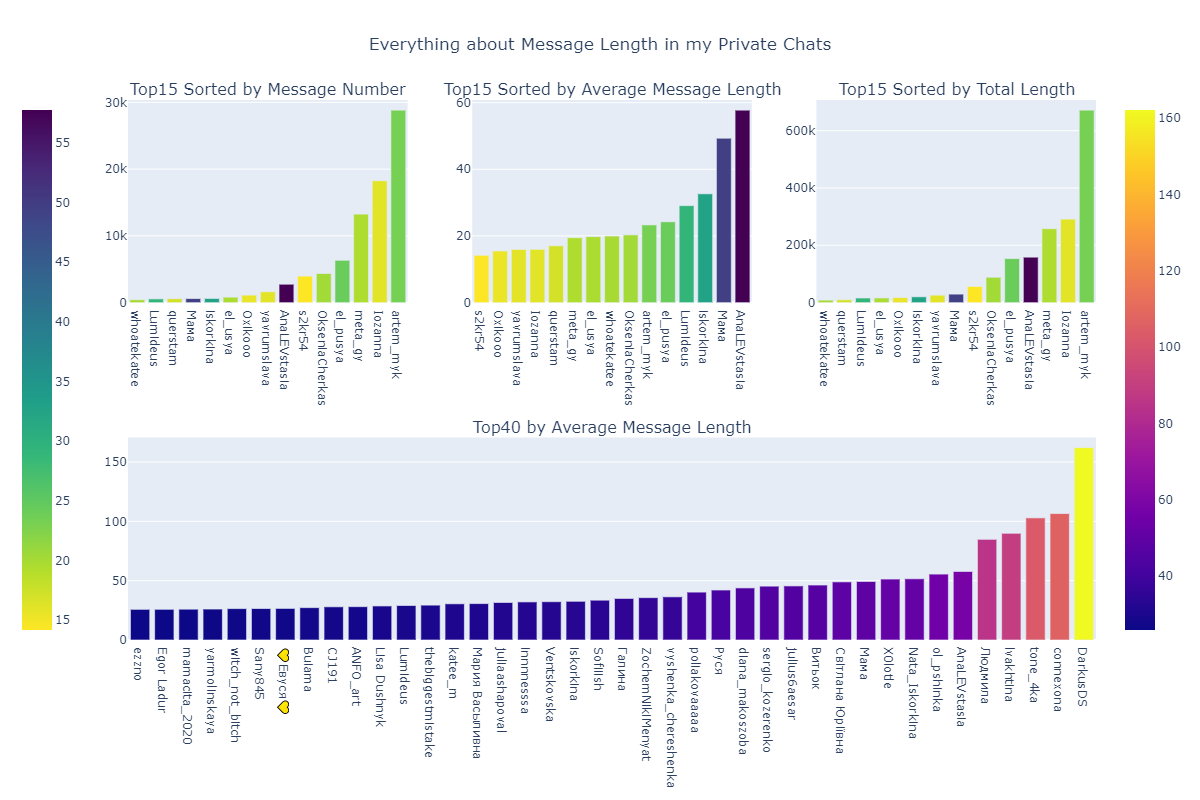

## Task 5.4 - 5.7
#### Analyze amount to duration time correlation for videos and voices sent from different users.

#### Preparing DataFrames

In [ ]:
df3 = df[(df["from_id"] != "PeerUser(user_id=561326466)") & (df["to_id"] == "561326466")].groupby(["dialog_id", "type"])["duration"].sum()
df31 = pd.Series.to_frame(df3[:, "video"].sort_values(ascending=False)[0:30])
df32 = pd.Series.to_frame(df3[:, "voice"].sort_values(ascending=False)[0:30])
df31["username"] = [users[i] for i in df31.index]
df32["username"] = [users[i] for i in df32.index]
df31.rename(columns = {'duration': 'total duration'}, inplace = True)
df32.rename(columns = {'duration': 'total duration'}, inplace = True)
df4 = df[(df["from_id"] != "PeerUser(user_id=561326466)") & (df["to_id"] == "561326466")].groupby(["dialog_id", "type"])["duration"].count()
df31["number"] = [df4[i, "video"] for i in df31.index]
df31["average duration"] = df31["total duration"] / df31["number"]
df32["number"] = [df4[i, "voice"] for i in df32.index]
df32["average duration"] = df32["total duration"] / df32["number"]

### Top10 Voice & Video Total Duration & Average Duration Users
#### (plot from 4 bar subplots)

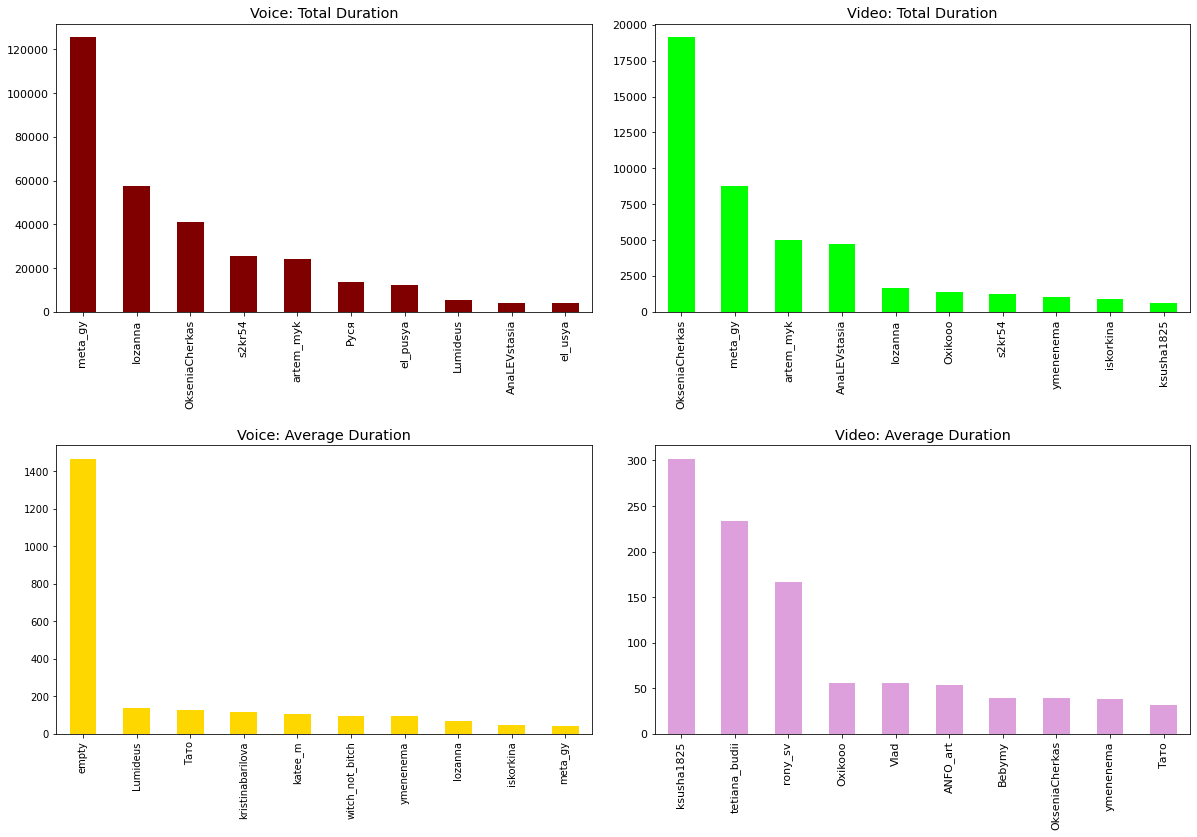

In [33]:
plt.rcParams.update({'font.size': 12})
print("\n")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,12))

df31.set_index(["username"])["total duration"].sort_values(ascending=False)[0:10].plot(kind="bar", title="Video: Total Duration", figsize=(17,12), fontsize=11, ax=axes[0,1], color="lime").set_xlabel("")
df31.set_index(["username"])["average duration"].sort_values(ascending=False)[0:10].plot(kind="bar", title="Video: Average Duration", figsize=(17,12), fontsize=11, ax=axes[1,1], color="plum").set_xlabel("")

df32.set_index(["username"])["total duration"].sort_values(ascending=False)[0:10].plot(kind="bar", title="Voice: Total Duration", figsize=(17,12), fontsize=11, ax=axes[0,0], color="maroon").set_xlabel("")
df32.set_index(["username"])["average duration"].sort_values(ascending=False)[0:10].plot(kind="bar", title="Voice: Average Duration", figsize=(17,12), fontsize=10, ax=axes[1,0], color="gold").set_xlabel("")
fig.tight_layout(pad=1.7)
plt.show()

### Understanding how different people send voices and videos
#### (short but a lot or long but few)
#### little analysis of social media behaviour patterns

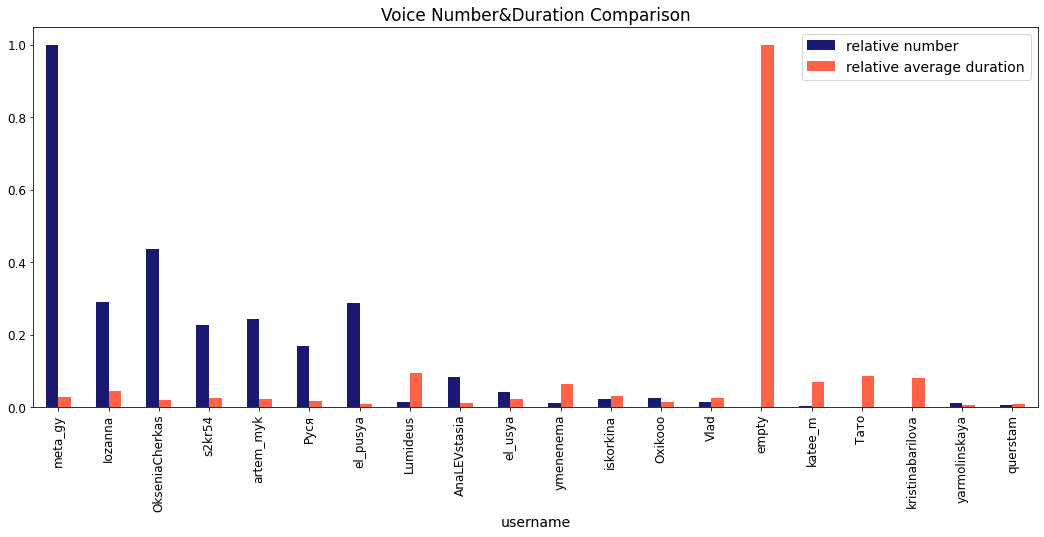

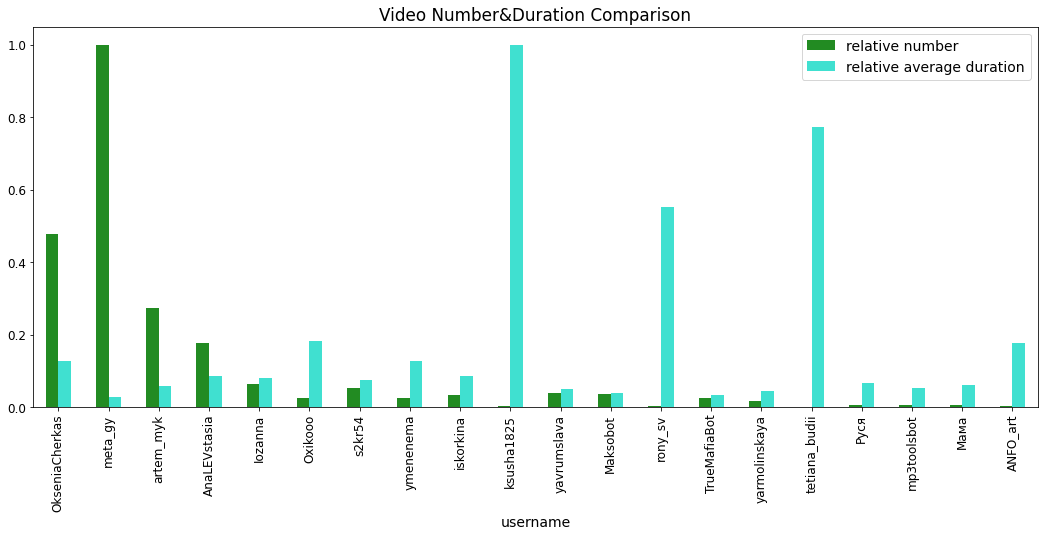

In [34]:
plt.rcParams.update({'font.size': 14})

print("\n")
df322 = df32.copy()
df322["number"] = df322["number"] / df322["number"].max()
df322["average duration"] = df322["average duration"] / df322["average duration"].max()

df322.set_index(["username"])[["number", "average duration"]][0:20].plot(kind="bar", title="Voice Number&Duration Comparison", figsize=(18,7), fontsize=12, color=["midnightblue", "tomato"])
plt.legend(["relative number", "relative average duration"])
plt.show()

print("\n\n")
df311 = df31.copy()
df311["number"] = df311["number"] / df311["number"].max()
df311["average duration"] = df311["average duration"] / df311["average duration"].max()
print("\n")

df311.set_index(["username"])[["number", "average duration"]][0:20].plot(kind="bar", title="Video Number&Duration Comparison", figsize=(18,7), fontsize=12, color=["forestgreen", "turquoise"])
plt.legend(["relative number", "relative average duration"])
plt.show()

## Task 5.8-5.13
#### Filial Group's Top10 Senders Total analysis.
#### Parameters: languages, number of unique words, parts of speech, words frequency etc.

#### Preparing DataFrame

In [21]:
def str_to_dict(string: str) -> dict:
    return ast.literal_eval(string)

In [22]:
top10_char = pd.read_csv("top10.csv")
top10_char["frequency4"] = top10_char["frequency4"].apply(lambda x: str_to_dict(x))
top10_char["frequency6"] = top10_char["frequency6"].apply(lambda x: str_to_dict(x))
top10_char["lang"] = top10_char["lang"].apply(lambda x: str_to_dict(x))
top10_char["parts of speech"] = top10_char["parts of speech"].apply(lambda x: str_to_dict(x))
top10_char["words"] = top10_char["words"].apply(lambda x: ast.literal_eval(x))
top10_char = top10_char.rename(columns={"Unnamed: 0" : ""})
top10_char.set_index("", drop=True, inplace=True)

In [206]:
dfl = pd.DataFrame(index=top10_char.index, columns=["uk", "ru", "other", "en"])
uk, ru, en, other = [], [], [], []
for k in top10_char["lang"].values:
    uk.append(k['uk'])
    ru.append(k['ru'])
    en.append(k['en'])
    other.append(k['other'])
dfl["uk"] = uk
dfl["ru"] = ru
dfl["en"] = en
dfl["other"] = other

### Message Languages Proportion for Top10 senders to Filial
#### (stacked and multiple horizontal bar plots)

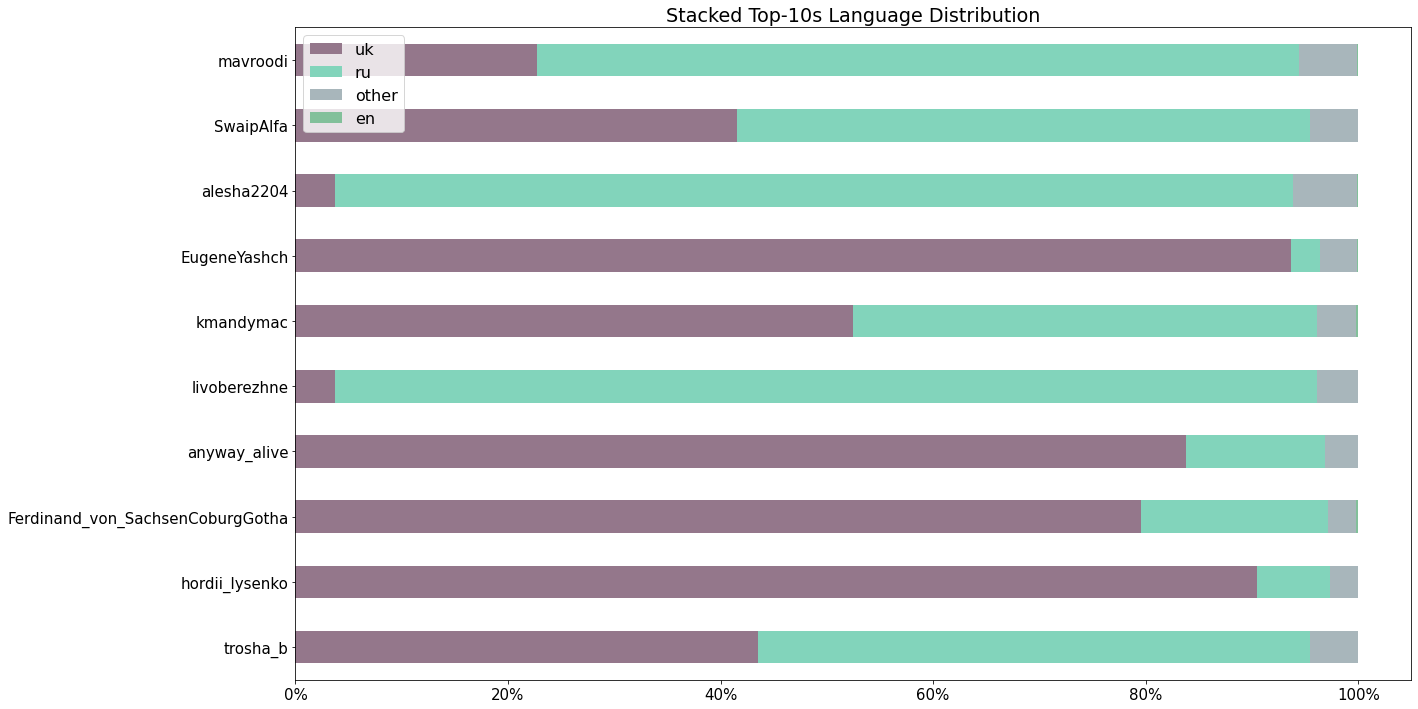

In [208]:
plt.rcParams.update({'font.size': 16})
print("")
percents1 = [str(i*20)+"%" for i in range(6)]
sticks1 = [i*20 for i in range(6)]
dfl.plot.barh(figsize=[20, 12], stacked=True, title="Stacked Top-10s Language Distribution", fontsize=15, color=["#94778B", "#82D4BB", "#A8B6BB","#82C09A"]).set_xticks(sticks1, percents1)
plt.show()

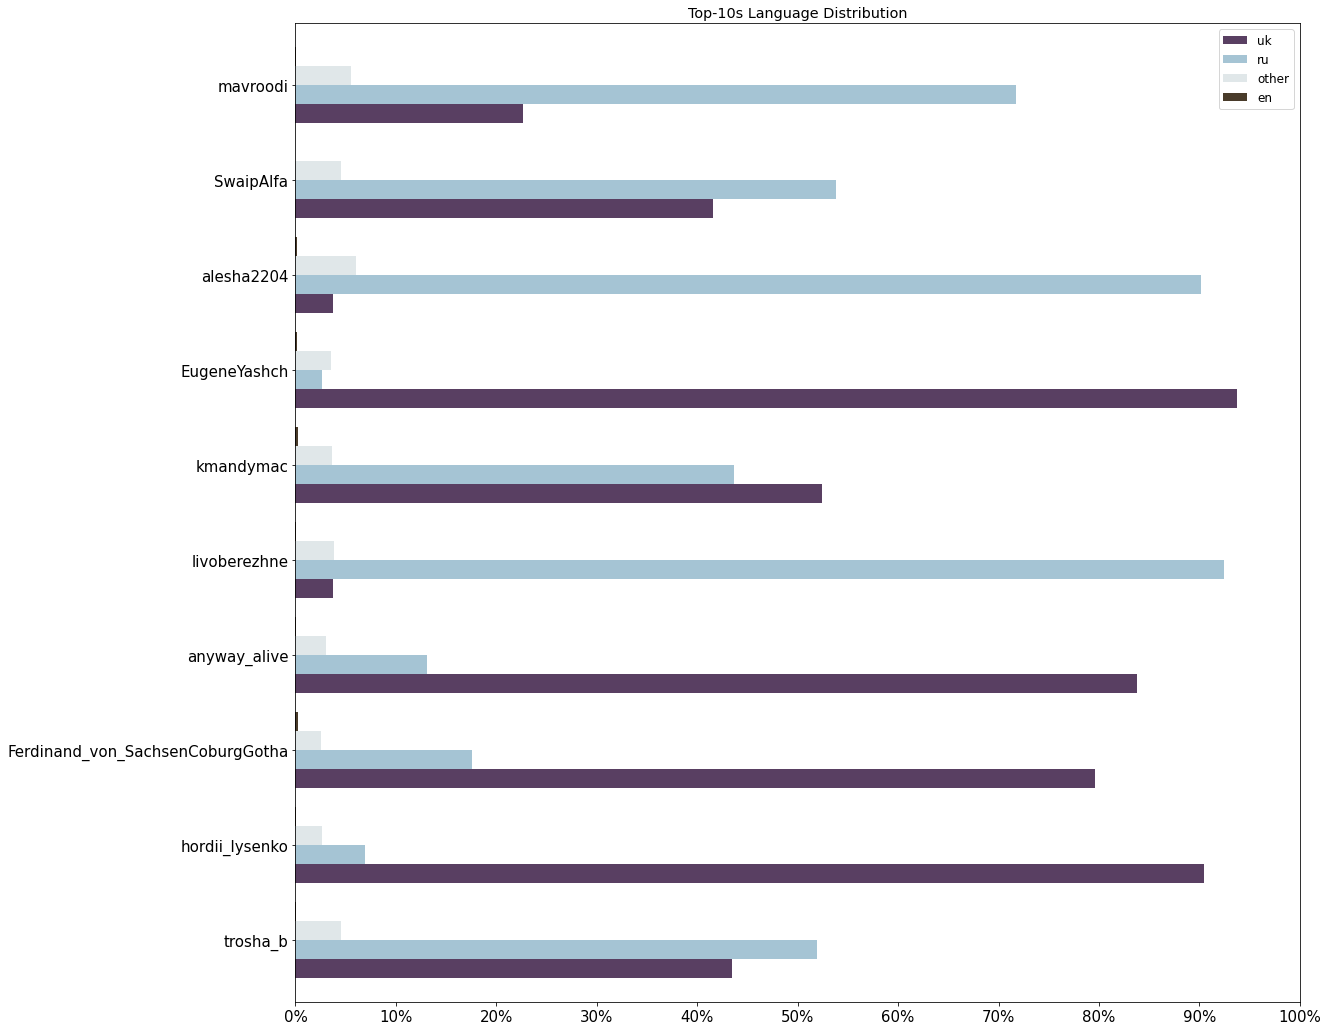

In [207]:
print("\n\n")
percents2 = [str(i*10)+"%" for i in range(11)]
sticks2 = [i*10 for i in range(11)]
dfl.plot.barh(figsize=[18, 18], title="Top-10s Language Distribution", fontsize=15, color=["#593F62", "#A5C4D4", "#E0E7E9", "#493B2A"], width=0.8).set_xticks(sticks2, percents2)
plt.show()

### Total Languages Proportion in Filial
#### (treemap plot with squarify)

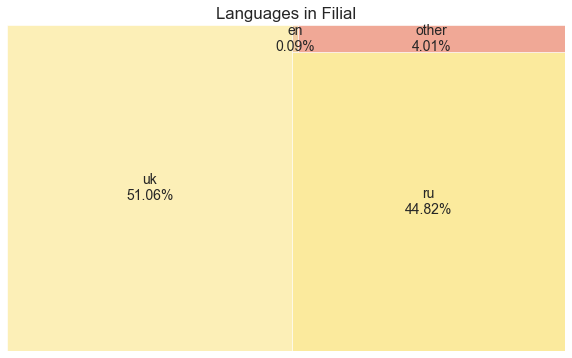

In [738]:
plt.rcParams.update({'font.size': 14})

lang11 = [85191, 74780, 154, 11, 17, 6690]
labels = ["uk\n51.06%", "ru\n44.82%", "en\n0.09%", "other\n4.01%"]
values = lang11.copy()
values.pop(3)
values.pop(3)

colors=['#fae588','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']

fig = plt.figure(figsize=(10, 6))
ax=fig.add_subplot(111)
sns.set_style(style="whitegrid")
squarify.plot(sizes=values, label=labels, alpha=0.6, color=colors, ax=ax).set(title="Languages in Filial")
plt.axis('off')
plt.show()

In [27]:
freq4 = {}
freq6 = {}
fr4 = top10_char["frequency4"].values
fr6 = top10_char["frequency6"].values

for i in range(10):
    for j in fr4[i].keys():
        if j in freq4.keys():
            freq4[j] = fr4[i][j] + freq4[j]
        else:
            freq4[j] = fr4[i][j]
            
    for j in fr6[i].keys():
        if j in freq6.keys():
            freq6[j] = fr6[i][j] + freq6[j]
        else:
            freq6[j] = fr6[i][j]

### Where words from words frequency top-10 >4 and >6 symbols coincide (Top-10 Filial Senders)
#### (histogram)

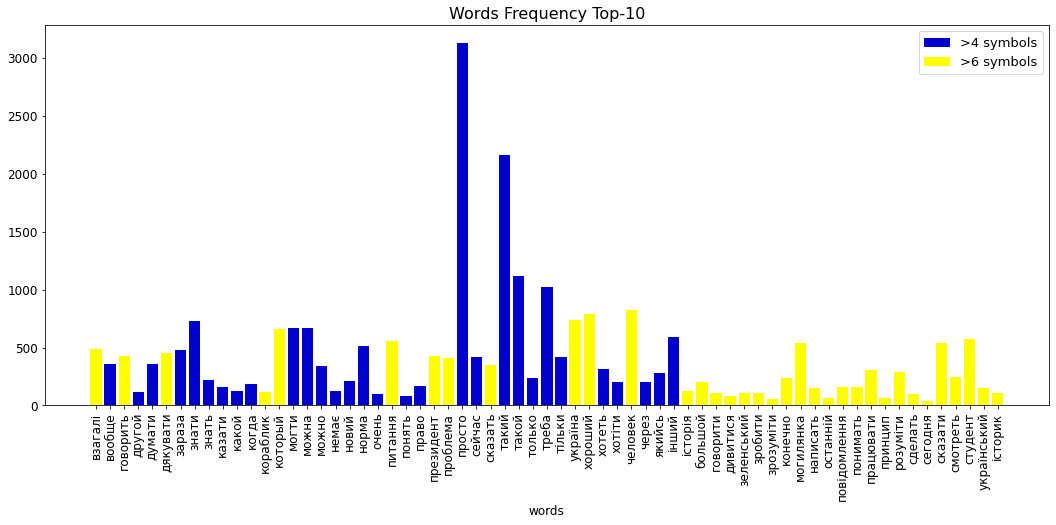

In [28]:
print("")
plt.rcParams.update({'font.size': 12})
f, ax= plt.subplots(figsize=(18,7))

plt.bar(*zip(*sorted(freq4.items())), color="mediumblue")
plt.bar(*zip(*sorted(freq6.items())), color="yellow")

plt.xticks(rotation=90)
ax.legend([">4 symbols", ">6 symbols"], fontsize=13)
ax.set_xlabel("words")
ax.set_title("Words Frequency Top-10", fontsize=16)
plt.show()

### Parts of speech usage for Top-10 Filial Senders
#### (rainbow scatter plot)

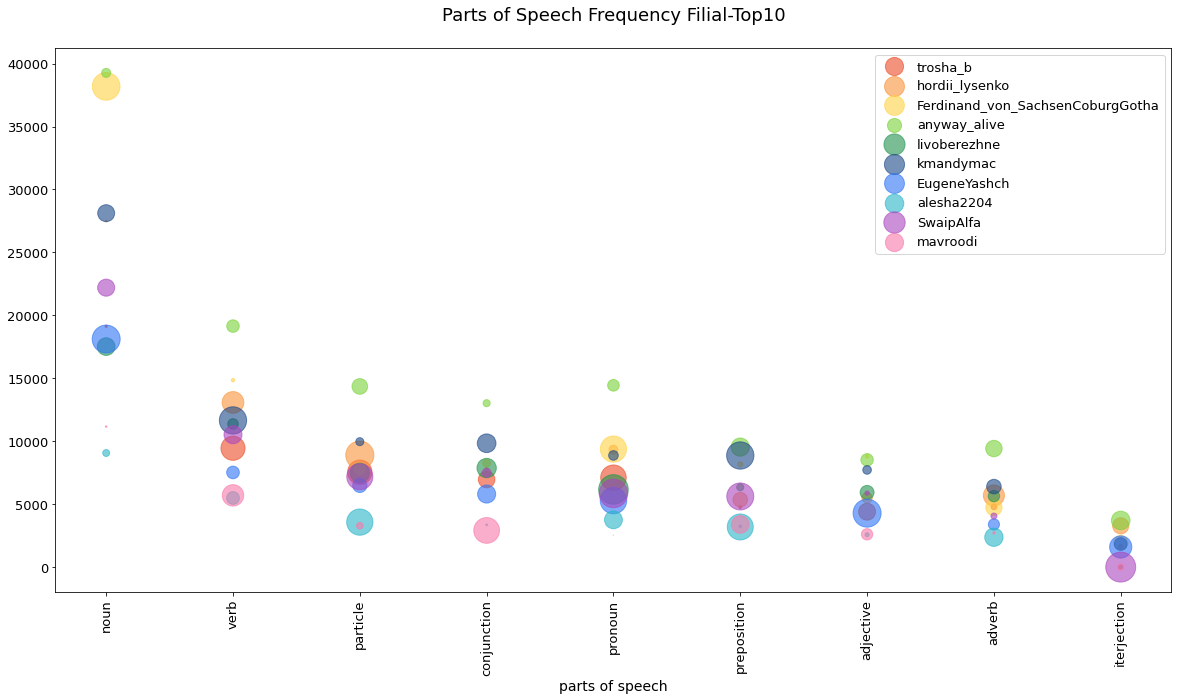

In [131]:
plt.rcParams.update({'font.size': 13})
x = {"noun": "NOUN", "verb": "VERB", "particle": "PRCL", "conjunction": "CONJ", "pronoun": "NPRO", "preposition":"PREP", "adjective":"ADJF", "adverb": "ADVB", "iterjection": "INTJ"}
di= {}
d = top10_char["parts of speech"].values

for i in range(10):
    for j in d[i].keys():
        if j in di.keys():
            di[j] = d[i][j] + di[j]
        else:
            di[j] = d[i][j]
            
fig, ax = plt.subplots(figsize=(20,10))
colors = ["#ec4c28", "#fb9439", "#ffd246", "#78d237", "#22924f", "#1b4887", "#2d73f5", "#28b4c8", "#aa46be", "#f978aa"]
for i in range(10):
    area = (30*np.random.rand(9))**2
    d = top10_char.iat[i, 6].copy()
    xi = list(x.keys())
    if ("INFN" in d.keys()): d["VERB"] = d["INFN"] + d["VERB"]
    yi = [d[i] if i in d.keys() else 0 for i in x.values()]
    plt.scatter(xi, yi, alpha=0.6, s=area, color=colors[i])
plt.xticks(rotation=90)
print("")
ax.legend([i for i in top10_char.index], fontsize=13)
ax.set_xlabel("parts of speech", fontsize=14)
ax.set_title("Parts of Speech Frequency Filial-Top10", fontsize=18, y=1.04)
plt.show()


### Number of unique (distinct) words to number of all words for Top-10 Filial Senders
#### (interactive cool circle graph with plotly.express)

In [198]:
list_people = list(top10_char.index.values)
pal = list(sns.color_palette(palette='plasma_r', n_colors=len(list_people)).as_hex())
alls = [len(list(i)) for i in top10_char["words"].values]
uniques = [i for i in top10_char["unique"].values]
color_person = dict(zip(list_people, pal))
color_person["all messages from current user"] = "#b9b9b9"
dictpers = dict(zip())

print("")
use = list_people + list_people
percents = [float((uniques[i]/alls[i])*100) for i in range(10)] + [float(100*(1 - (uniques[i]/alls[i]))) for i in range(10)]
label_color = list_people + ["all messages from current user" for i in range(10)]

fig = px.scatter(x=percents, y=use, color=label_color, text = [str("{:.1f}".format(i))+' %' for i in percents], opacity=1, color_discrete_map=color_person) 
fig.update_layout(height = 1100, plot_bgcolor = 'white', margin = dict(t=40, l=10, r=10, b=20), legend=dict(title='Users'), showlegend=True, title={'text': "Distinct Words %", 'y':0.95, 'x':0,'xanchor': 'left', 'yanchor': 'top'}) 
k = 0
for p in list_people:
    fig.add_shape(type="line", layer="below", line=dict(color=color_person.get(p), width=5), y0=p, x0=percents[k], y1=p, x1=percents[k+10])
    k+=1

fig.update_traces(textposition='top center', marker={'size':58}, textfont=dict(color='black'))
fig.update_yaxes(title='users', visible=True, showgrid =False)
fig.update_xaxes(visible=True, title="%", showgrid =False, range=[0,100]) 
fig.show()

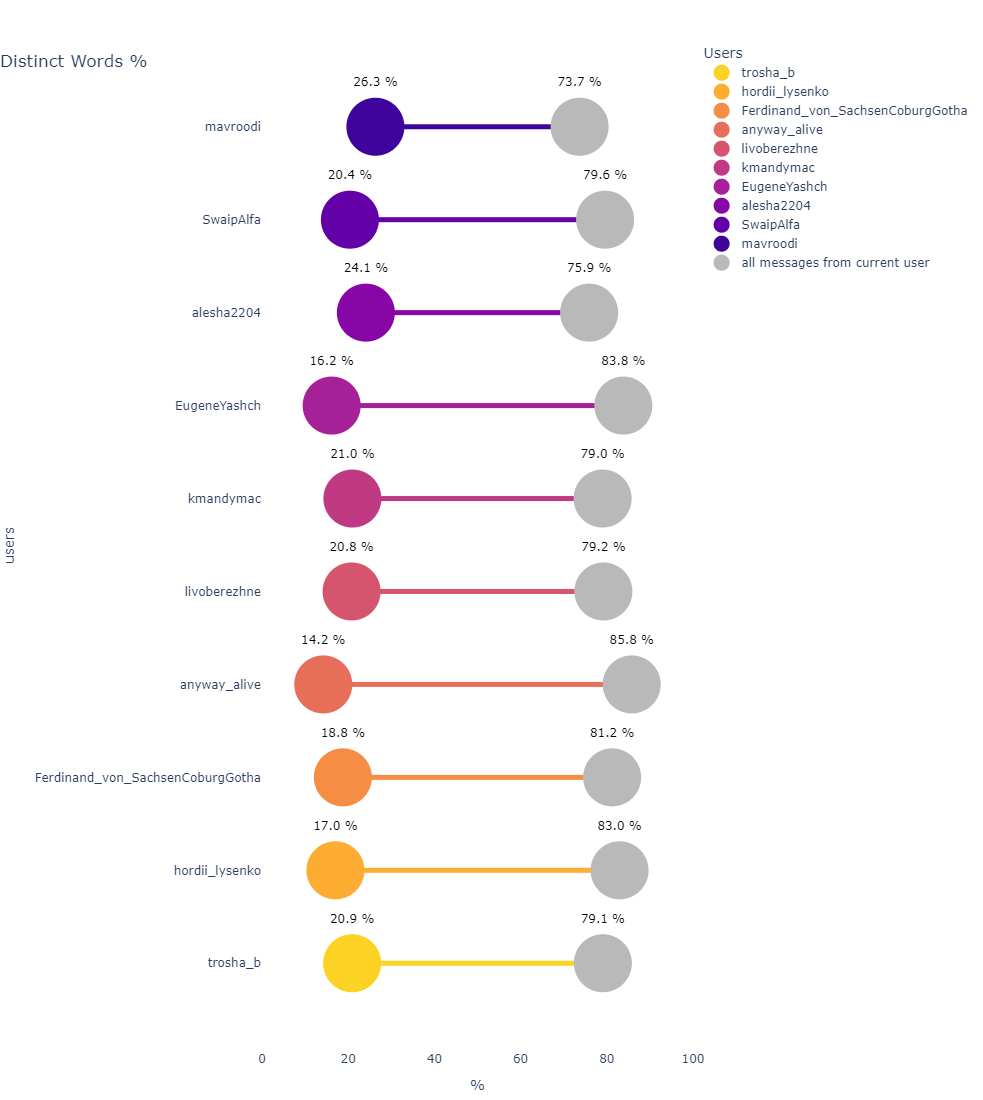

## Task 5.14-5.16
#### Analysis of my vocabulary usage.

#### Preparing Data

In [106]:
rdate_df = df.copy()
rdate_df["date"]= pd.to_datetime(rdate_df["date"]).dt.strftime('%Y-%m-%d')
rdate_df = rdate_df.sort_values("date")

sent_ru = rdate_df[(rdate_df["from_id"] == 'PeerUser(user_id=561326466)') & (rdate_df["type"] == "text") & (rdate_df["date"] < "2022-02-23") & (rdate_df["fwd_from"].isna())]
sent_uk = rdate_df[(rdate_df["from_id"] == 'PeerUser(user_id=561326466)') & (rdate_df["type"] == "text") & (rdate_df["date"] > "2022-02-23") & (rdate_df["fwd_from"].isna())]

In [ ]:
rmv_digits = str.maketrans("","",digits)
msg = [str(i) for i in list(sent_uk["message"].values)]
text = re.sub(r'[^\w\s]', '', " ".join(msg).lower().replace("\n", " ").translate(rmv_digits))
normuk = []
for i in text.split(" "):
    normuk.append(morphuk.parse(i)[0].normal_form)

frequk = {}
moreuk = []
freq4 = {}
more4 = []
for i in normuk:
    if (len(i)>6): moreuk.append(i)
            
c = Counter(moreuk).most_common(100)
for item in c:
    frequk[item[0]] = item[1]
    
for i in normuk:
    if (len(i)>3): more4.append(i)
            
c = Counter(more4).most_common(100)
for item in c:
    freq4[item[0]] = item[1]

#### Function to easily build circles plots 

In [101]:
def dict_to_circle_plot(title: str, d: dict, palette: list, fontsize: float):
    circles = circlify.circlify(list(d.values()), show_enclosure=False, target_enclosure=circlify.Circle(x=0, y=0))
    circles.reverse()
    
    if(isinstance(list(d.keys())[0], tuple)):
        labels = [str(k[0] + " " + k[1])+'<br>'+str(v) for k, v in d.items()]
    else:
        labels = [str(k)+'<br>'+str(v) for k, v in d.items()]
    fig, ax = plt.subplots(figsize=(14,14), facecolor='white')
    ax.axis('off')
    lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim) 
    
    for circle, note, color in zip(circles, labels, palette): 
        x, y, r = circle 
        ax.add_patch(plt.Circle((x, y), r, alpha=1, color = color)) 
        plt.annotate(note.replace('<br>','\n'), (x,y), va='center', ha='center', fontsize=max(min(fontsize*(circle.r**1/2)*20, 18), 11))
   
    ax.set_title(title, fontsize=20)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### I started speaking Ukrainian everywhere only after 24 January 2022. So I got interested to compare my words usage in Ukrainian and russian languages. Before and after russia's full-scaled invasion on our territory.

#### Two types of comparison: between >6 symbols words top50 and between >4 symbols words top100

#### (4 circles plots with circlify and cool palettes)

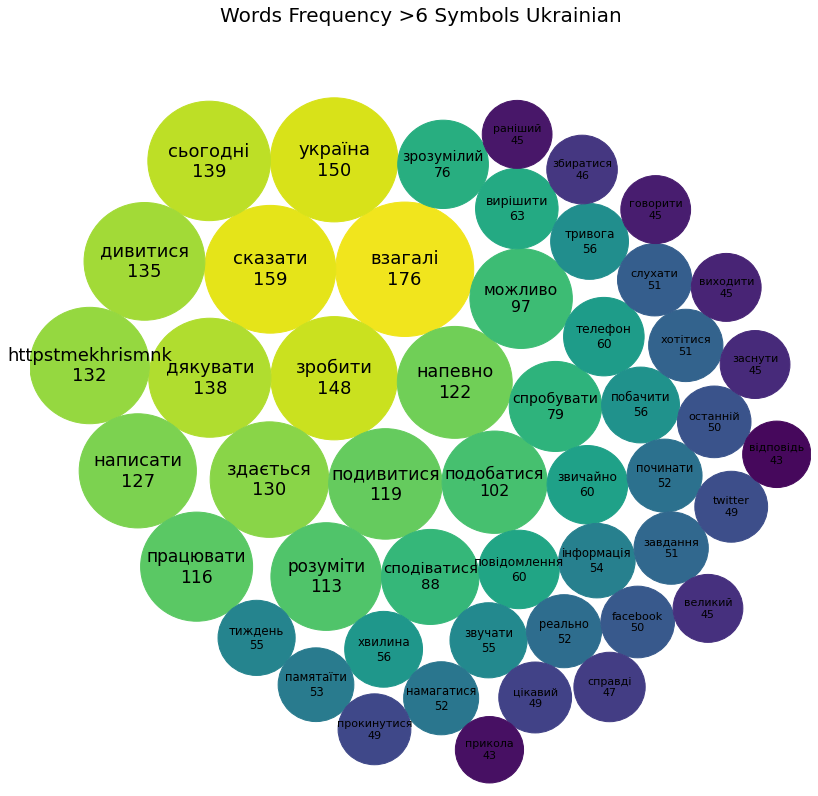

In [732]:
print("")
pal = list(sns.color_palette(palette='viridis_r', n_colors=50).as_hex())
d = dict([(k,frequk[k]) for k in list(frequk.keys())[0:50]])
dict_to_circle_plot("Words Frequency >6 Symbols Ukrainian", d, pal, 12)

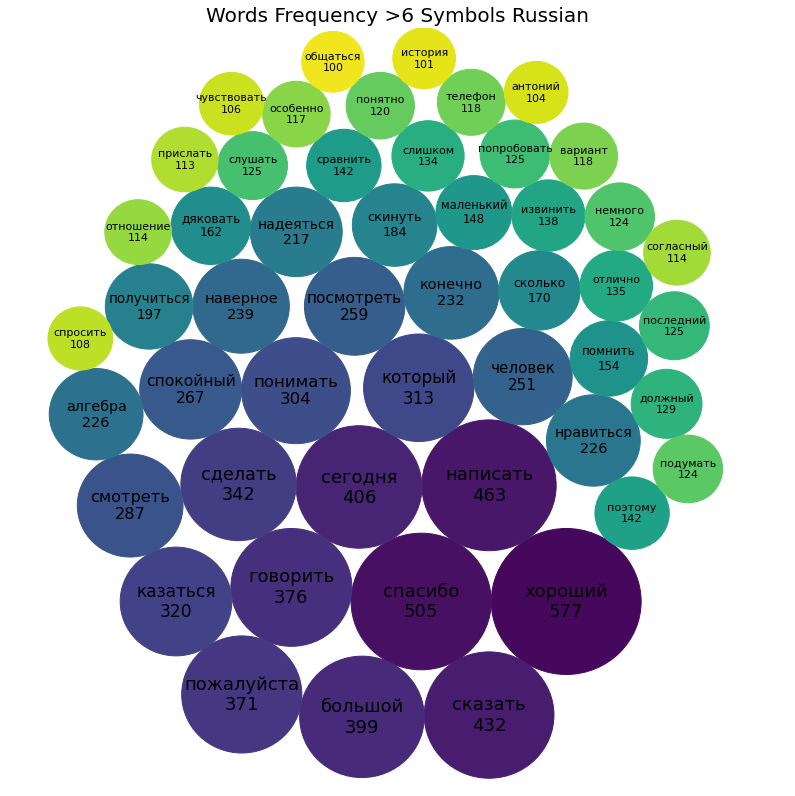

In [733]:
print("")
pal = list(sns.color_palette(palette='viridis', n_colors=50).as_hex())
d = dict([(k,freq6[k]) for k in list(freq6.keys())[0:50]])
dict_to_circle_plot("Words Frequency >6 Symbols Russian", d, pal, 12)

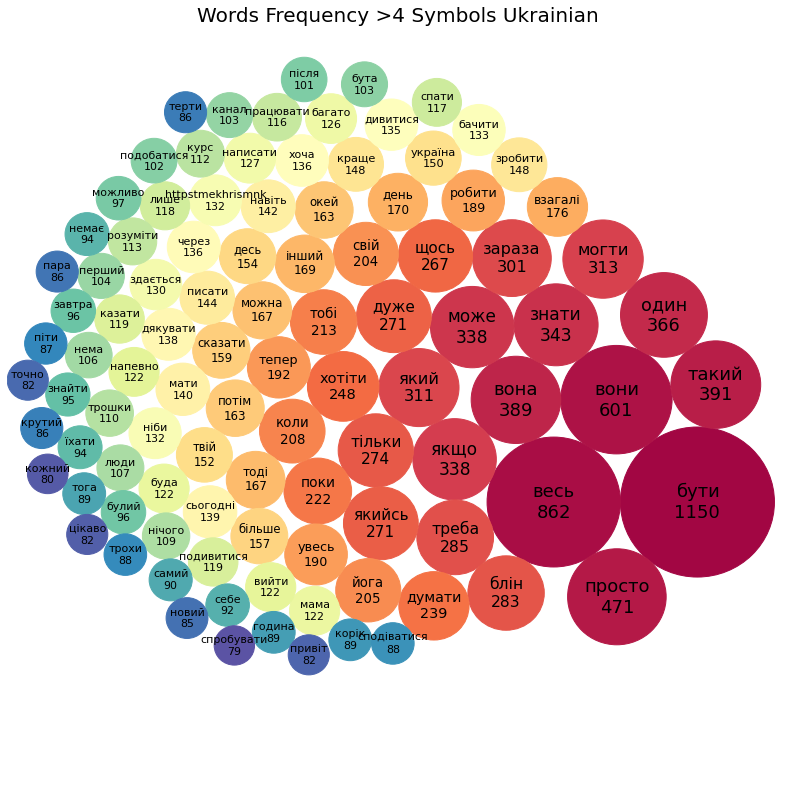

In [734]:
print("")
pal = list(sns.color_palette(palette='Spectral', n_colors=100).as_hex())
d = dict([(k,freq4[k]) for k in list(freq4.keys())[0:100]])
dict_to_circle_plot("Words Frequency >4 Symbols Ukrainian", d, pal, 16)

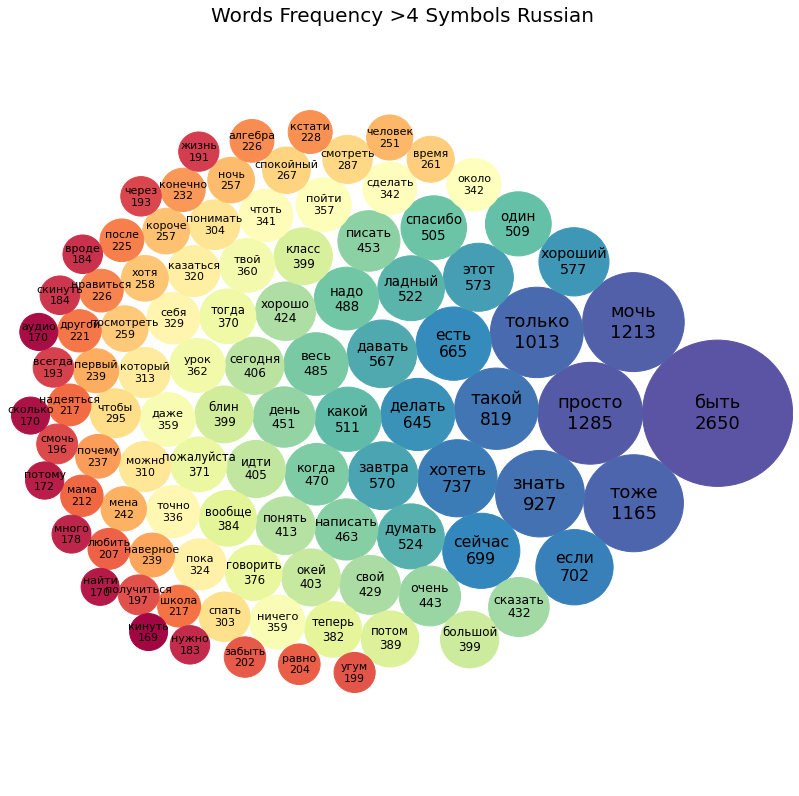

In [735]:
print("")
pal = list(sns.color_palette(palette='Spectral_r', n_colors=100).as_hex())
d = dict([(k,freq[k]) for k in list(freq.keys())[0:100]])
dict_to_circle_plot("Words Frequency >4 Symbols Russian", d, pal, 16)

#### Preparing data for bigrams

In [107]:
rmv_digits = str.maketrans("","",digits)
msg = []
for i in sent_uk["message"].values:
    msg.append(re.sub(r'[^\w\s]', '', str(i).lower().replace("\n", " ").translate(rmv_digits)))
bigrams = [b for m in msg for b in zip(m.split(" ")[:-1], m.split(" ")[1:]) if b[0]!="" and b[1]!=""]
bifreq = {}       
c = Counter(bigrams).most_common(50)
for item in c:
    bifreq[item[0]] = item[1]

In [108]:
i=2
bigrams_more_i = [b for m in msg for b in zip(m.split(" ")[:-1], m.split(" ")[1:]) if len(b[0])>i and len(b[1])>i]
bifreq_more_i = {}          
c = Counter(bigrams_more_i).most_common(50)
for item in c:
    bifreq_more_i[item[0]] = item[1]

In [133]:
i=3
bigrams_more_3i = [b for m in msg for b in zip(m.split(" ")[:-1], m.split(" ")[1:]) if len(b[0])>i and len(b[1])>i]
bifreq_more_3i = {}          
c = Counter(bigrams_more_3i).most_common(50)
for item in c:
    bifreq_more_3i[item[0]] = item[1]

NameError: name 'msg' is not defined

### Bigrams for me (Ukrainian period)
#### three different: >2symb, >3symb.
#### (2 more circles plots with circlify)

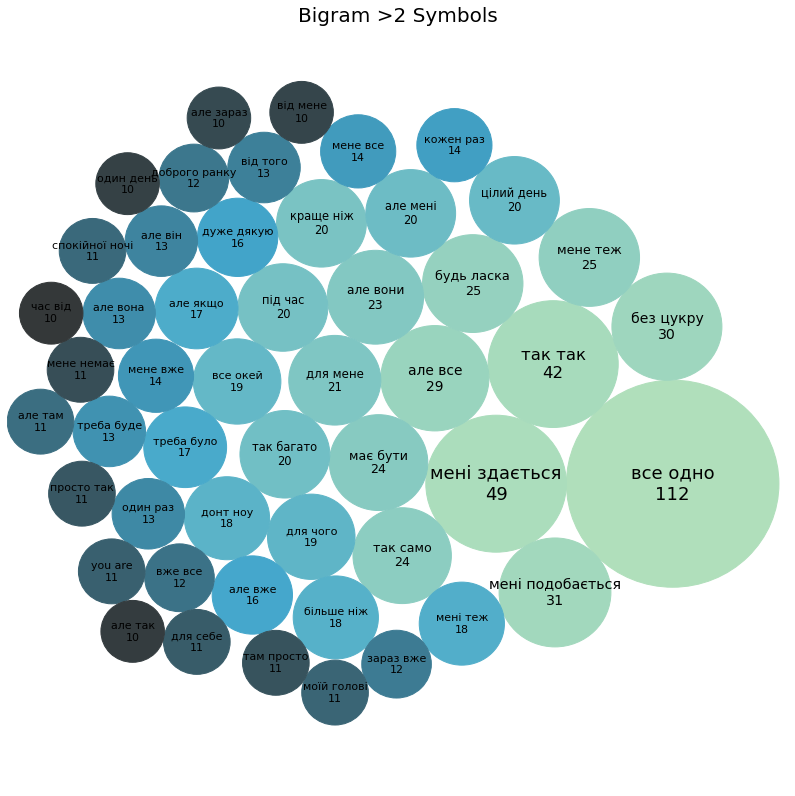

In [111]:
print("")
dict_to_circle_plot("Bigram >2 Symbols", bifreq_more_i, pal, 10)

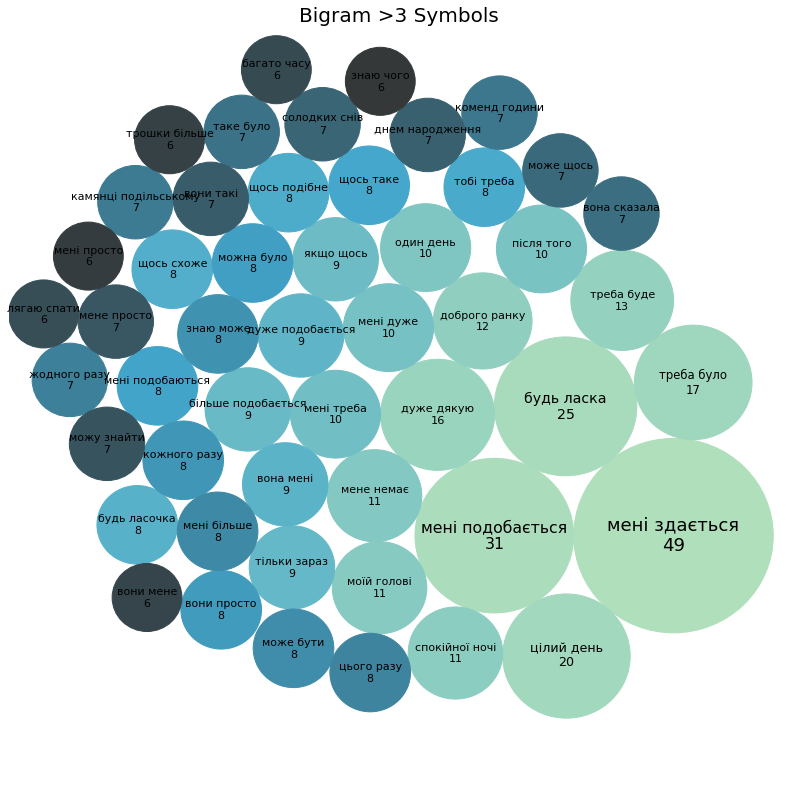

In [115]:
print("")
dict_to_circle_plot("Bigram >3 Symbols", bifreq_more_3i, pal, 8)

## Task 5.17
### Usage of words for Top10 users in private chats

#### Preparing Data

In [30]:
df5 = pd.Series.to_frame(df[df["dialog_id"]>0].groupby(["dialog_id"])["message"].count().sort_values(ascending=False)[0:10])
df5.insert(0, "username", [users[i] for i in df5.index])

In [31]:
rdate_df = df.copy()
rdate_df["date"]= pd.to_datetime(rdate_df["date"]).dt.strftime('%Y-%m')
rdate_df = rdate_df.sort_values("date")
rdate_df["message"] = rdate_df["message"] + " "

In [32]:
dfu = pd.DataFrame(columns=["username", "date, Y-m", "unique/all, %"])
rmv_digits = str.maketrans("","",digits)
d = 0
unique_n = []
dates = []
usernames = []
for i in range(10):
    user = "PeerUser(user_id=" + str(df5.index[i]) + ")"
    dfi = rdate_df[(rdate_df["from_id"]==user) & (rdate_df["type"]=="text") & (rdate_df["fwd_from"].isna())].groupby(["date"])["message"].sum()
    for date in dfi.index:
        all_words = re.sub(r'[^\w\s]', '', str(dfi[date]).lower().replace("\n", "").translate(rmv_digits)).split(" ")
        all_words = [str(i) for i in all_words if i]
        unique_words = len(set(all_words))
        if (len(all_words) < 150): continue
        else: u_n = (unique_words/len(all_words)) * 100
        usernames.append(df5.at[df5.index[i], "username"])
        dates.append(date)
        unique_n.append(u_n)
        d+=1


dfi = rdate_df[(rdate_df["from_id"]=="PeerUser(user_id=561326466)") & (rdate_df["type"]=="text") & (rdate_df["fwd_from"].isna())].groupby(["date"])["message"].sum()
for date in dfi.index:
        all_words = re.sub(r'[^\w\s]', '', str(dfi[date]).lower().replace("\n", "").translate(rmv_digits)).split(" ")
        all_words = [str(i) for i in all_words if i]
        unique_words = len(set(all_words))
        if (len(all_words) < 150): continue
        else: u_n = (unique_words/len(all_words)) * 100
        usernames.append("ymenenema")
        dates.append(date)
        unique_n.append(u_n)
        d+=1

In [33]:
dfu["username"] =usernames
dfu["date, Y-m"] = dates
dfu["unique/all, %"] = unique_n

### Part of different words forms to all words in time (for top10 private chats users and me) - IQ or Vocab progression or regression
#### month counts when all number of words sent is >=150
#### (interactive line plot with 10 lines each for different user with plotly)

In [199]:
pal = list(sns.color_palette(palette="gnuplot2", n_colors=11).as_hex())
var = ["ymenenema"] + list(df5["username"].values)
fig = go.Figure(px.scatter(title="Different Words Part in Time", height=500, width=1100))
for d,p in zip(var, pal):
    fig.add_trace(go.Scatter(x = dfu[dfu["username"]==d]["date, Y-m"], y =dfu[dfu["username"]==d]['unique/all, %'], name=d, line_color=p, fill=None, mode='lines'))

fig.update_layout(xaxis_title="date", yaxis_title="different words %", title_x=0.5)
fig.show()

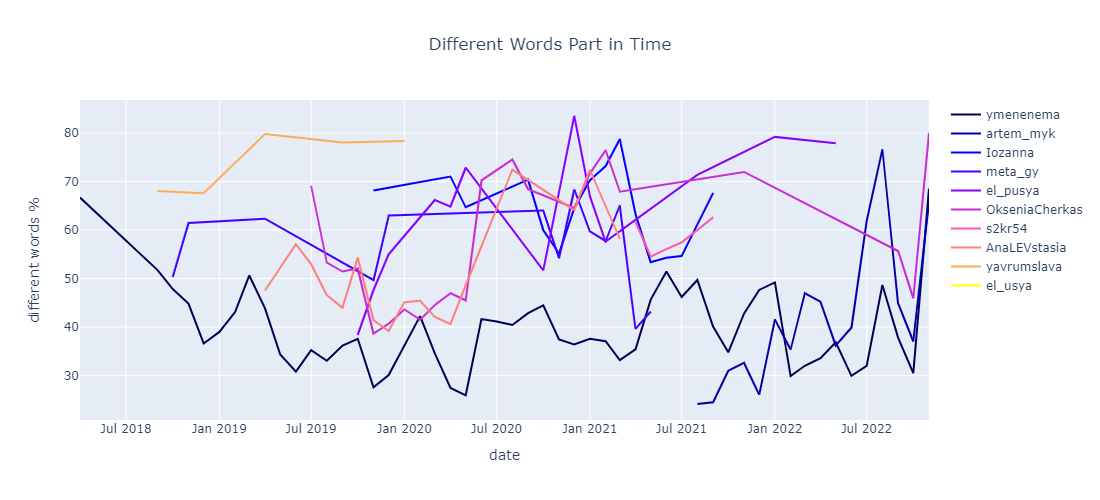

## Task 5.18
#### My voice to text proportion in time.

In [201]:
rdate_df = df.copy()
rdate_df["date"]= pd.to_datetime(rdate_df["date"]).dt.strftime('%Y-%m')
rdate_df = rdate_df.sort_values("date")
dfm = rdate_df[(rdate_df["from_id"]=="PeerUser(user_id=561326466)") & (rdate_df["type"]=="text") & (rdate_df["fwd_from"].isna())].groupby(["date"])["message"].sum()
dfv = rdate_df[(rdate_df["from_id"]=="PeerUser(user_id=561326466)") & (rdate_df["type"]=="voice") & (rdate_df["fwd_from"].isna())].groupby(["date"])["duration"].sum()
dfvid = rdate_df[(rdate_df["from_id"]=="PeerUser(user_id=561326466)") & (rdate_df["type"]=="video") & (rdate_df["fwd_from"].isna())].groupby(["date"])["duration"].sum()

for i in dfm.index:
    dfm[i] = len(dfm[i].replace("\n", ""))/2.5

dates, mtov, m, v = [], [], [], []
for i in dfm.index:
    dates.append(i)
    vid = 0
    if i in dfvid.index: vid = dfvid[i]
    if i in dfv.index: 
        mtov.append((dfv[i]/dfm[i]) * 100)
        m.append(dfm[i]/(dfv[i]+dfm[i]+vid) * 100)
        v.append(dfv[i]/(dfv[i]+dfm[i]+vid) * 100)
    else:
        mtov.append(0)
        m.append((dfm[i]/(dfm[i]+vid)) * 100)
        v.append(0)


### Time I spent to write messages and to record voices in all chats
#### how it changed with time: text/voices progression
#### (interactive line plot with three lines each for one correlation with plotly)

In [202]:
pal = list(sns.color_palette("hls", 9).as_hex())
layout = Layout(paper_bgcolor='rgba(0,0,0,0)', )
fig = go.Figure(px.scatter(title="My Time Spent on Voice/Text in %", height=500, width=1100))
fig.add_trace(go.Scatter(x = dates, y =mtov, name="Voice/Text, %", line_color=pal[4], fill=None, line_shape='spline'))
fig.add_trace(go.Scatter(x = dates, y =m, name="Text/All, %", line_color=pal[6], fill=None,line_shape='spline'))
fig.add_trace(go.Scatter(x = dates, y =v, name="Voice/All, %", line_color=pal[8], fill=None, line_shape='spline'))
fig.update_layout(xaxis_title="date", yaxis_title="%", plot_bgcolor='rgba(0,0,0,0)')
fig.show()

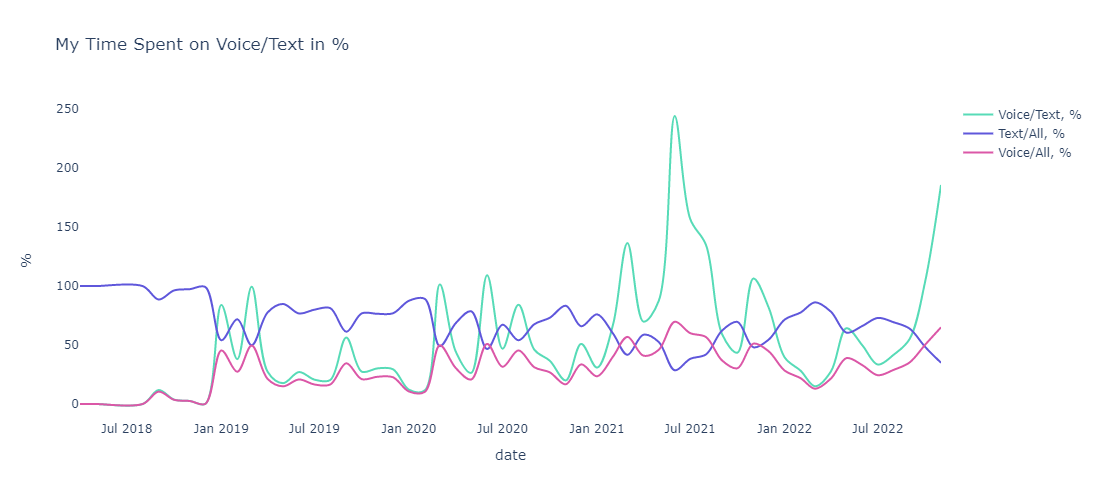

## Task 5.19-5.20
### a few tasks with df_meta (meta data for chats)

### Percentages of different types of chats in my telegram
#### (treemap with squarify)

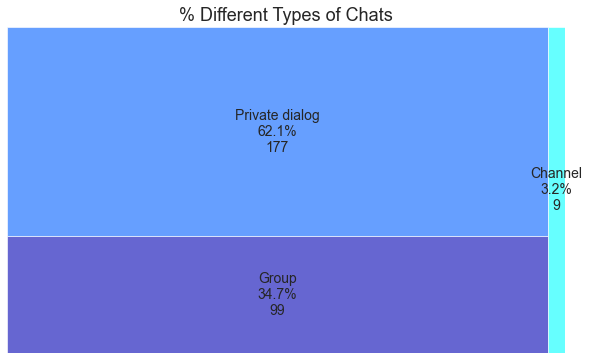

In [987]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.titlesize': 18})
sum = 99+177+9
values=[99/sum, 177/sum, 9/sum]
labels = ["Group\n34.7%\n99", "Private dialog\n62.1%\n177", "Channel\n3.2%\n9"]
colors=["#0000b3", "#0060ff", "#00ffff"]
fig = plt.figure(figsize=(10, 6))
ax=fig.add_subplot(111)
sns.set_style(style="whitegrid")
squarify.plot(sizes=values, label=labels, alpha=0.6, color=colors, ax=ax).set(title="% Different Types of Chats")
plt.axis('off')
plt.show()

### Number of connections with different people through different types of chats
#### (treemap with squarify) - I'm purposely using squares instead of pie chart because of what you remarked at the lesson 

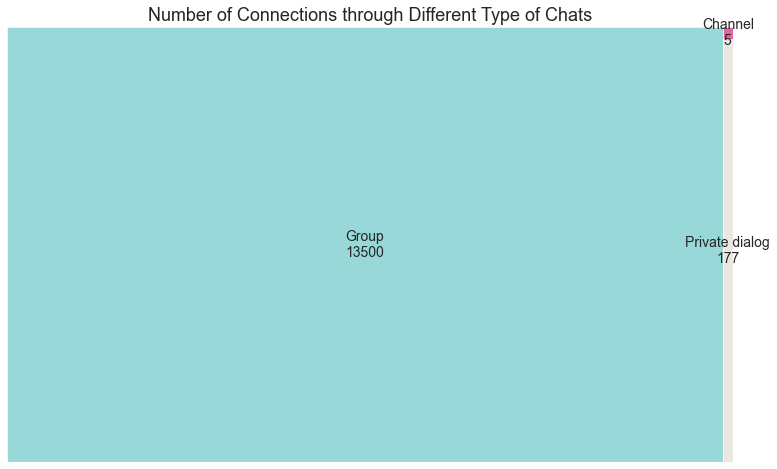

In [994]:
sum = 13500+177+5
values=[13500/sum, 177/sum, 5/sum]
labels = ["Group\n13500", "Private dialog\n177", "Channel\n5"]
colors =["#54bebe", "#dedad2", "#c80064"]
fig = plt.figure(figsize=(13, 8))
ax=fig.add_subplot(111)
sns.set_style(style="whitegrid")
squarify.plot(sizes=values, label=labels, alpha=0.6, color=colors, ax=ax).set(title="Number of Connections through Different Type of Chats")
plt.axis('off')
plt.show()

## Task 5.21-5.22
#### Continuing to work with meta data
### Analysis of Languages Proportions in Names

#### Identifying language in first+last names from different chats types

In [37]:
tran = Translator()
dfe = pd.DataFrame(index=["all_name_surname", "groupname", "private_name_surname"], columns=["uk", "ru", "en", "other"])

dictlang = {'uk':0,'ru':0, 'en':0, 'other':0}
all_name_surname = list(df_meta["users"].values)
all_name_surname = list(set([str(i.split(", ")[1][15:-1] + " " + i.split(", ")[2][14:-1]) if i.split(", ")[2][13:0]!="" else i.split(", ")[1][15:-1] for i in all_name_surname]))
for i in all_name_surname:
    l = tran.detect(i).lang
    if l in list(dictlang.keys()):
        dictlang[l] +=1
    else:
        dictlang["other"]+=1

grouplang = {'uk':0,'ru':0, 'en':0, 'other':0}
all_group = list(set(df_meta[df_meta["type"]!="Private dialog"]["name"].values))
for i in all_group:
    l = tran.detect(i).lang
    if l in list(grouplang.keys()):
        grouplang[l] +=1
    else:
        grouplang["other"]+=1

privlang = {'uk':0,'ru':0, 'en':0, 'other':0}
priv_name_surname = list(set(df_meta[df_meta["type"]=="Private dialog"]["name"].values))
for i in priv_name_surname:
    l = tran.detect(i).lang
    if l in list(privlang.keys()):
        privlang[l] +=1
    else:
        privlang["other"]+=1

KeyboardInterrupt: 

In [ ]:
dfe["uk"] = [dictlang["uk"], grouplang["uk"], privlang["uk"]]
dfe["ru"] = [dictlang["ru"], grouplang["ru"], privlang["ru"]]
dfe["en"] = [dictlang["en"], grouplang["en"], privlang["en"]]
dfe["other"] = [dictlang["other"], grouplang["other"], privlang["other"]]

In [38]:
dfe = pd.read_csv("dfe.csv")
dfe = dfe.rename(columns={"Unnamed: 0" : ""})
dfe.set_index("", drop=True, inplace=True)

### Language Proportions in different types of names (users first&last, groupname etc.)
#### (interactive bar plot and group bar plot with plotly.express)

In [203]:
print("\n\n")
color_discrete_map = {'uk':"blue", "ru":"purple","en":"red"}
fig =px.bar(dfe.loc["all_name_surname", "uk":"en"], title="All Users First & Last Names Language Proportion",color_discrete_map=color_discrete_map, color=list(dfe.columns.values)[0:3], labels={"color": "language"})
fig.update_layout(title_xanchor="left", title_x=0.23, width=800)
fig.update_traces(width=0.5)
fig.update_xaxes(title="")
fig.update_yaxes(title="number")
fig.show()
print("\n\n")
color_discrete_map = {'uk':"forestgreen", "ru":"lime","en":"yellow"}
text = {'uk':"ukr", "ru":"rus","en":"eng"}

fig =px.bar(dfe.iloc[1:3, 0:3], x=list(dfe.index.values)[1:3], y =["uk", "ru", "en"], barmode="group", color_discrete_map=color_discrete_map, labels={"variable": "language"})
fig.update_traces(width=0.2)
fig.update_layout(title="Language Proportion in Group Names and Private Usernames", title_x=0.5, bargap=0.35)
fig.update_layout(barmode="group")
fig.update_xaxes(title="")
fig.update_yaxes(title="number")

for i, t in enumerate(["uk", "ru", "en"]):
    fig.data[i].text = t
    fig.data[i].textposition = "inside"

fig.show()

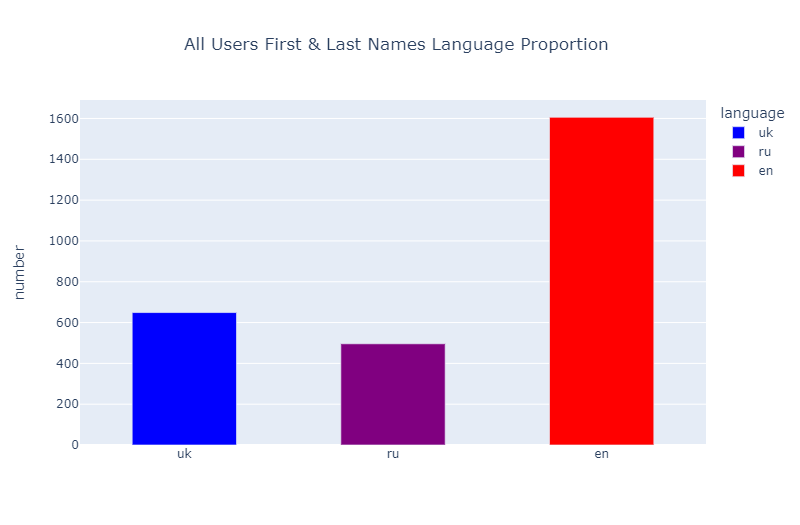

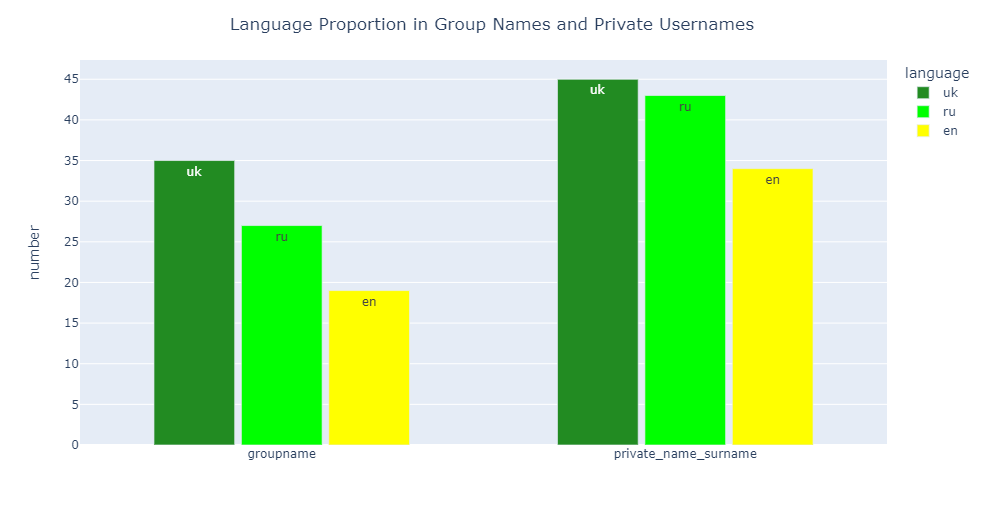

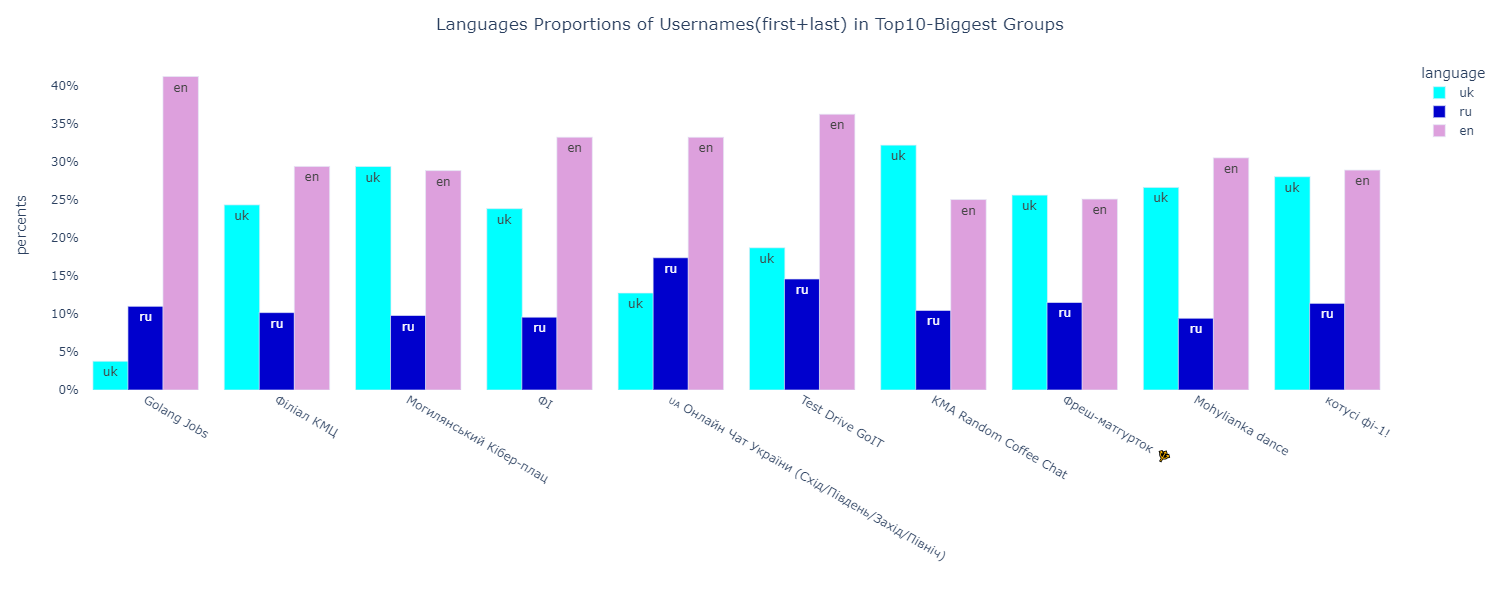

#### Preparing DataFrame with group-to-group language info

In [1369]:
tran = Translator()
c = Counter(df_meta[df_meta["type"]=="Group"]["name"].values).most_common(100)[10:]

names, _ = zip(*c)
for name in names:
    grlang = {'uk':0, "ru":0, "en":0}
    grl = list(set([str(i.split(", ")[1][15:-1] + " " + i.split(", ")[2][14:-1]) if i.split(",")[2][13:0]!="" else i.split(", ")[1][15:-1] for i in list(df_meta[df_meta["name"]==name]["users"].values)]))
    k = 0
    for i in grl:
        k+=1
        l = tran.detect(i).lang
        if l in list(grlang.keys()):
            grlang[l] +=1
            
    dfe.loc[name] = [(grlang['uk']/k) * 100, (grlang['ru']/k) * 100, (grlang['en']/k) *100, None]

🇺🇦 Русанівка - маскувальні сітки
🇺🇦 Русанівка - маскувальні сітки
КМА І GameDev І Н2’22
КМА І GameDev І Н2’22
canadian bitches
canadian bitches
Applicants for Toronto
Applicants for Toronto
ФОРЕЛЬKN
ФОРЕЛЬKN
DL курс
DL курс
Дискретна математика — КН 2021
Дискретна математика — КН 2021
Алгебра та геометрія КН 2021
Алгебра та геометрія КН 2021
МА КН 2021-2022
МА КН 2021-2022
Диф.рівняння КН 2022
Диф.рівняння КН 2022
Мат.логіка і теорія алгоритмів 2022
Мат.логіка і теорія алгоритмів 2022
EDUKOHT Team
EDUKOHT Team
what is ЗСУ
what is ЗСУ
КС VIII
КС VIII
2019 Model of Council of Europe (P.G. Tychyny 191)
2019 Model of Council of Europe (P.G. Tychyny 191)
Сікрєтні Котики НаУКМА
Сікрєтні Котики НаУКМА
актори вахтьори
актори вахтьори
7-3
7-3
Треш канада
Треш канада
Чат ІТ Марафон
Чат ІТ Марафон
тУсьА
тУсьА
136 UNSC 2019 ФЛУД
136 UNSC 2019 ФЛУД
Крупа без Гречки
Крупа без Гречки
FRONTEND - DAN.IT
FRONTEND - DAN.IT
EDUWELCOME
EDUWELCOME
Vankay
Vankay
RL Mafia
RL Mafia
нова епоха англодиктатури
но

In [1376]:
dfe = dfe[(dfe["uk"]!=0) | (dfe["ru"]!=0) | (dfe["en"]!=0)]
dfe["id"] = [-3, -2, -1] + [i+1 for i in range(dfe.shape[0]-3)]

                                           uk          ru          en   other  \
all_name_surname                   649.000000  496.000000  1606.00000  1961.0   
groupname                           35.000000   27.000000    19.00000    27.0   
private_name_surname                45.000000   43.000000    34.00000    55.0   
Golang Jobs                          3.786575   11.015491    41.26506     NaN   
Філіал КМЦ                          24.367510   10.186418    29.42743     NaN   
...                                       ...         ...         ...     ...   
It is group                         66.666667    0.000000     0.00000     NaN   
ПИЗДЕЦ ПАССАНЫ ЗАВТРА КР ПО ХИМИИ    0.000000   33.333333     0.00000     NaN   
🌸🌸🌸                                  0.000000   33.333333     0.00000     NaN   
Кини                                33.333333   33.333333     0.00000     NaN   
хей герлс итс лайф                  50.000000    0.000000     0.00000     NaN   

                           

In [1509]:
c = Counter(df_meta[df_meta["type"]=="Group"]["name"].values).most_common(100)
groups = dict((k[0], k[1]) for k in c)
group_size = [None, None, None]
for i in dfe.index[3:]:
    group_size.append(groups[i])
dfe["group size"] = group_size

{'Golang Jobs': 5040, 'Філіал КМЦ': 2593, 'Могилянський Кібер-плац': 1387, 'ФІ': 817, '🇺🇦 Онлайн Чат України (Схід/Південь/Захід/Північ)': 604, 'Test Drive GoIT': 572, 'KMA Random Coffee Chat': 439, 'Фреш-матгурток 🔱': 219, 'Mohylіanka dance': 218, 'котусі фі-1!': 120, '🇺🇦 Русанівка - маскувальні сітки': 115, 'КМА І GameDev І Н2’22': 101, 'canadian bitches': 100, 'Applicants for Toronto': 79, 'ФОРЕЛЬKN': 57, 'DL курс': 53, 'Дискретна математика — КН 2021': 53, 'Алгебра та геометрія КН 2021': 51, 'МА КН 2021-2022': 49, 'Диф.рівняння КН 2022': 44, 'Мат.логіка і теорія алгоритмів 2022': 43, 'EDUKOHT Team': 43, 'what is ЗСУ': 37, 'КС VIII': 31, '2019 Model of Council of Europe (P.G. Tychyny 191)': 28, 'Сікрєтні Котики НаУКМА': 25, 'актори вахтьори': 24, '7-3': 23, 'Треш канада': 23, 'Чат ІТ Марафон': 21, 'тУсьА': 21, '136 UNSC 2019 ФЛУД': 21, 'Крупа без Гречки': 19, 'FRONTEND - DAN.IT': 19, 'EDUWELCOME': 18, 'Vankay': 17, 'RL Mafia': 16, 'нова епоха англодиктатури': 16, 'Практикум з молеку

### Languages Proportions of Usernames(first+last) in All my Groups
#### (interactive scatter plot with plotly)

In [204]:
print("")
color_discrete_map = {'uk':"#e27c7c", "ru":"#333333","en":"#6cd4c5"}
dfcurrr= dfe[3:].copy()
dfcurrr["size"] = [i**1/18 for i in dfcurrr["group size"].values[0:5]] + [i**1/4 for i in dfcurrr["group size"].values[5:10]] + [i for i in dfcurrr["group size"].values[10:30]] + [i*1.5 for i in dfcurrr["group size"].values[30:55]] + [i*3 for i in dfcurrr["group size"].values[55:]]

fig = px.scatter(dfcurrr, x="id", y=["uk", "ru", "en"], width=1400, height=550, hover_data=[dfcurrr.index, "id", "group size"], color_discrete_map=color_discrete_map, labels={"id": "group number", "value":"part in percents", "variable": "language", "index": "groupname"}, size='size')
fig.update_layout(title="Languages Proportions of Usernames(first+last) in ALL my Groups", title_x=0.5, plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(nticks=40, range=(-3, 93), gridcolor='rgba(0,0,7,0.05)', showline=True, linecolor="Black")
fig.update_yaxes(ticktext=[str(i*10) + "%" for i in range(10)], tickmode='array', tickvals=[i*10 for i in range(10)], gridcolor='rgba(0,0,7,0.05)', showline=True, linecolor="Black")
fig.show()

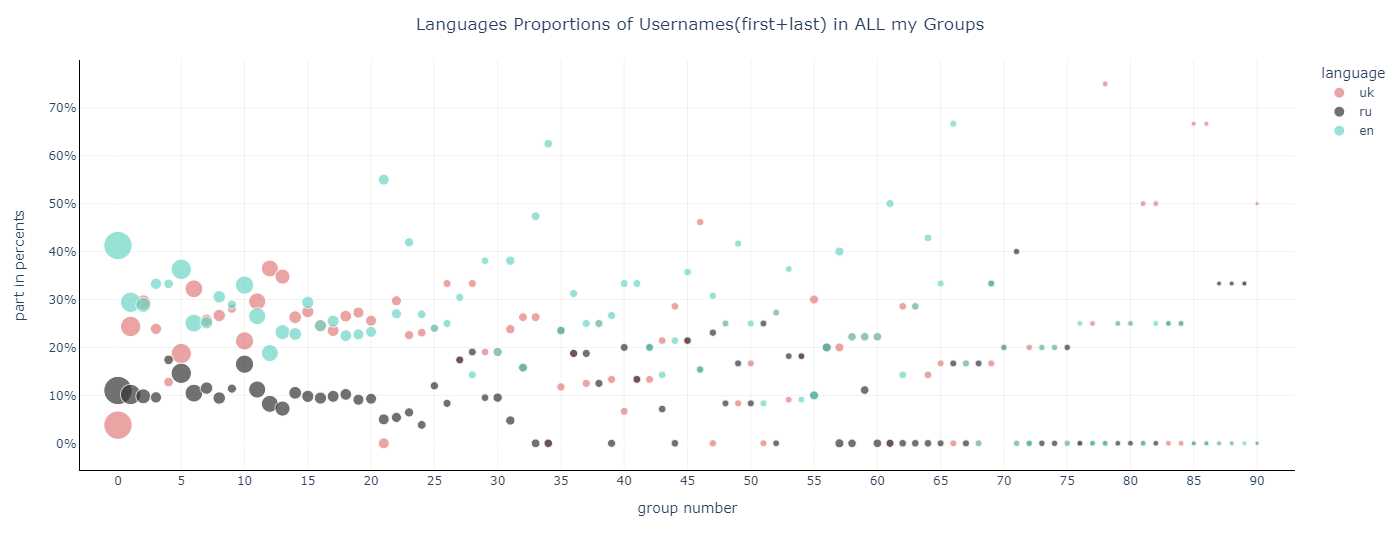

## Task 5.23
### Identifying mobile operators

In [41]:
other = []
mobile_numbers_all = []
for i in df_meta["users"].values:
    if i[-5:-1]!="None":
        if i[-14:-11] == "380":
            mobile_numbers_all.append(i[-12:-9])
        else: other.append(i[-15:-2])
            
other = [i.replace("'", "").replace(" ", "") for i in other]

other_priv = []
mobile_numbers_priv = []
for i in list(df_meta[df_meta["type"]=="Private dialog"]["users"].values):
    if i[-5:-1]!="None":
        if i[-14:-11] == "380":
            mobile_numbers_priv.append(i[-12:-9])
        else: 
            other_priv.append(i[-15:-2])

other_priv = [i.replace("'", "").replace(" ", "") for i in other_priv]


In [42]:
operators = {"Kyivstar" : ("039", "067", "068", "096", "097", "098"), "Vodafone": ("050", "066", "095", "099"), "lifecell": ("063","073","093")}
oper_all = dict((i, 0) for i in list(operators.keys()))
oper_priv = dict((i, 0) for i in list(operators.keys()))

for i in mobile_numbers_all:
    for k,v in operators.items():
        if i in v: oper_all[k] += 1

for i in mobile_numbers_priv:
    for k,v in operators.items():
        if i in v: oper_priv[k] += 1

In [43]:
oper_all["other countries"] = len(other)
oper_priv["other countries"] = len(other_priv)


### Mobile operators distribution among users (from all chats and from private dialogs)
#### (2 interactive pie chart subplots with plotly)

In [205]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
labels = list(oper_all.keys())
fig.add_trace(go.Pie(labels=labels, values=list(oper_all.values()), name="All users"),1, 1)
fig.add_trace(go.Pie(labels=labels, values=list(oper_priv.values()), name="Private users"),1, 2)
fig.update_traces(marker=dict(colors=[ 'royalblue', 'darkblue', 'cyan', 'lightcyan',]))

fig.update_layout(
    title_text="Mobile Operators Proportions",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='All', x=0.2, y=0.5, font_size=20, showarrow=False),
                 dict(text='Private', x=0.82, y=0.5, font_size=18, showarrow=False)])
fig.update_traces(hole=.4, hoverinfo="label+percent+value+name", textinfo="label+percent")
fig.show()

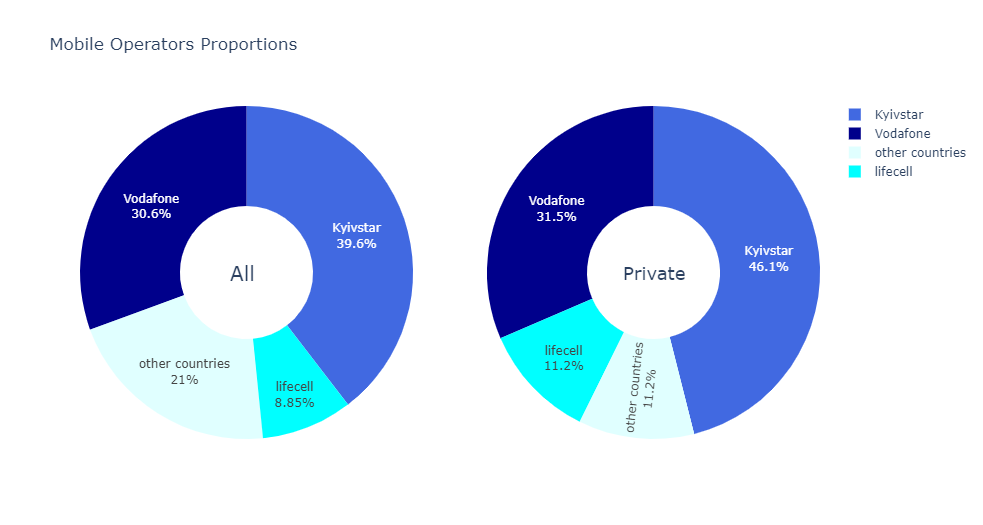

## Task 5.24
### Showing connections inside my social bubble. Between people with whom I have a private chat, which means I had a few communications with them.
### These connection graphs give an understanding of groups formed, different channels of interactions and some unexpected insights.

#### Building connection graphs + some helpful functions

In [225]:
def get_edges(meta: pd.DataFrame, flags_group_priv_channel: list) -> (list, list):
    edges = []
    edges_labels =[]
    
    if list[0]:
        for chat in meta[meta["type"]=="Group"].groupby(["dialog_id"]):
            this_group_users = [str_to_dict(user)["username"] for user in chat[1]["users"].values]
            this_group_edges = [(i, j) for i in this_group_users for j in this_group_users if i!=j]
            edges += this_group_edges
            edges_labels += [chat[1]["name"].values[0] for i in range(len(this_group_edges))]
            
    if list[1]:
        for chat in meta[meta["type"]=="Private dialog"].groupby(["dialog_id"]):
            edges.append(("ymenenema", str_to_dict(chat[1]["users"].values[0])["username"]))
            edges_labels.append(chat[1]["name"].values[0])
            
    if list[2]:
        for chat in meta[meta["type"]=="Channel"].groupby(["dialog_id"]):
            if(len(chat[1]["users"].values)) > 1:
                this_channel_users = [str_to_dict(user)["username"] for user in chat[1]["users"].values]
                this_channel_edges = [(i, j) for i in this_channel_users for j in this_channel_users if i!=j]
                edges += this_channel_edges
                edges_labels += [chat[1]["name"].values[0] for i in range(len(this_channel_edges))]
            
    return edges, edges_labels

In [46]:
def get_nodes(meta: pd.DataFrame) -> list:
    return list(set([str_to_dict(user)["username"] for user in meta["users"].values] + ["ymenenema"]))

In [51]:
def build_graph(edges: list, nodes: list = []) -> nx.Graph:
    if len(nodes):
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
    else:
        G = nx.Graph(edges)
        
    return G

In [226]:
nodes = get_nodes(df_meta_all)
edges, edges_labels = get_edges(df_meta_all, [True, True, False])

[('artem_myk', 'mrdor1stan'), ('artem_myk', 'novaart06'), ('artem_myk', 'innnnesssa'), ('artem_myk', 'DMyronets'), ('artem_myk', 'kr0zer0'), ('artem_myk', 'x500miles'), ('artem_myk', 'thebiggestmistake'), ('artem_myk', 'entrimertad'), ('artem_myk', 'mapthree'), ('artem_myk', 'Kasgor'), ('artem_myk', 'bks00jk'), ('artem_myk', 'zcxzxcz'), ('artem_myk', 'artem_levv'), ('artem_myk', 'ymenenema'), ('mrdor1stan', 'artem_myk')]
['English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨']


In [228]:
priv_chat_nodes = [i for i in get_nodes(df_meta_all[df_meta_all["type"]=="Private dialog"]) if not ("bot" in i or "Bot" in i or i=="Stickers" or i=="Telegram")]
priv_chat_edges = []
priv_chat_edges_labels = []
for i in range(len(edges)):
    if(edges[i][0] in priv_chat_nodes and edges[i][1] in priv_chat_nodes):
        priv_chat_edges.append(edges[i])
        priv_chat_edges_labels.append(edges_labels[i])

privG = build_graph(priv_chat_edges, priv_chat_nodes)

[('artem_myk', 'mrdor1stan'), ('artem_myk', 'innnnesssa'), ('artem_myk', 'thebiggestmistake'), ('artem_myk', 'bks00jk'), ('artem_myk', 'zcxzxcz'), ('artem_myk', 'ymenenema'), ('mrdor1stan', 'artem_myk'), ('mrdor1stan', 'innnnesssa'), ('mrdor1stan', 'thebiggestmistake'), ('mrdor1stan', 'bks00jk'), ('mrdor1stan', 'zcxzxcz'), ('mrdor1stan', 'ymenenema'), ('innnnesssa', 'artem_myk'), ('innnnesssa', 'mrdor1stan'), ('innnnesssa', 'thebiggestmistake')]
['English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨', 'English ✨']


In [283]:
priv_chat_nodes_without_me = [i for i in get_nodes(df_meta_all[df_meta_all["type"]=="Private dialog"]) if not ("bot" in i or "Bot" in i or i=="Stickers" or i=="Telegram" or i=="ymenenema")]
priv_chat_edges_without_me = []
priv_chat_edges_labels_without_me = []
for i in range(len(priv_chat_edges)):
    if(priv_chat_edges[i][0] in priv_chat_nodes_without_me and priv_chat_edges[i][1] in priv_chat_nodes_without_me):
        priv_chat_edges_without_me.append(priv_chat_edges[i])
        priv_chat_edges_labels_without_me.append(priv_chat_edges_labels[i])

users_with_connections = set([user for tupl in priv_chat_edges_without_me for user in tupl])
priv_chat_nodes_without_me = [user for user in priv_chat_nodes_without_me if user in users_with_connections]
privG_connected_without_me = build_graph(priv_chat_edges_without_me, priv_chat_nodes_without_me)

#### Plotting interactive connection graphs with plotly

In [285]:
def plot_graph(G: nx.Graph, title: str = "", annotation: str = "", colorbar_title: str = "", colorscale: str = "pinkyl", reversescale: bool = False, edges_labels: list = []):
    pos = nx.spring_layout(G, k=0.8, iterations=100)
    for n, p in pos.items():
        G.nodes[n]['pos'] = p
        
    middle_node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=go.Marker(
            opacity=0,
            color = []
        )
    )
    
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.7, color='#888'),
        hoverinfo='none',
        mode='lines'
    )
    
    t = 0
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])
        middle_node_trace['x'] += tuple([(x0+x1)/2])
        middle_node_trace['y'] += tuple([(y0+y1)/2])
        middle_node_trace['text'] += tuple([str(edges_labels[t] + "<br>")])
        t+=1

    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale=colorscale,
            reversescale=reversescale,
            color=[],
            size=25,
            colorbar=dict(
                thickness=1,
                title=colorbar_title,
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=0)
        )
    )

    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])

    for node, adjacencies in enumerate(G.adjacency()):
        node_trace['marker']['color'] += tuple([len(adjacencies[1])])
        node_info = adjacencies[0]
        node_trace['text'] += tuple([node_info])
    
    fig = go.Figure(
            data=[middle_node_trace, edge_trace, node_trace],
            layout=go.Layout(
                title=title,
                titlefont=dict(size=16),
                font={'size' : 8},
                showlegend=False,
                width=1050,
                height=600,
                plot_bgcolor='rgba(0,0,0,0)',
                margin=dict(b=21, l=5, r=5, t=40),
                annotations=[dict(
                    text=annotation,
                    showarrow=False,
                    xref="paper", yref="paper"
                )],
                xaxis=dict(showgrid=False, zeroline=False,
                           showticklabels=False, mirror=True),
                yaxis=dict(showgrid=False, zeroline=False,
                           showticklabels=False, mirror=True)
            )
    )
    
    fig.show()

__This graph displays certain groups of people by interests/hobbies/places of work/study.<br>
Details__:
 - in the center - me
 - second darkest - friend from last school, who studies on my current faculty (is in "ФІ" chat)
 - the biggest pink cluster is our university (CS-2 course, some of professors)
 - the smaller and lighter one is my first school (previous classmates, current friends)
 - a little bit spreaded circles under me is my last school (classmates)
 - 6 nodes on the right is my additional english courses group (and one boy whom I cannot remember)
 - stretched triangle near it is my cousin's family
 - triangle on the top left are my teammates from one team competition

In [273]:
plot_graph(privG, title="Connections Inside My Social Bubble Centered On Me", colorbar_title="number of connections", colorscale="rdpu")

('English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'English ✨<br>1', 'canadian bitches<br>1', 'canadian bitches<br>1', 'canadian bitches<br>1', 'canadian bitches<br>1', 'canadian bitches<br>1', 'canadian bitches<br>1', 'EDUKOHT Team<br>1', 'EDUKOHT Team<br>1', 'EDUKOHT Team<br>1', 'EDUKOHT Team<br>1', 'EDUKOHT 

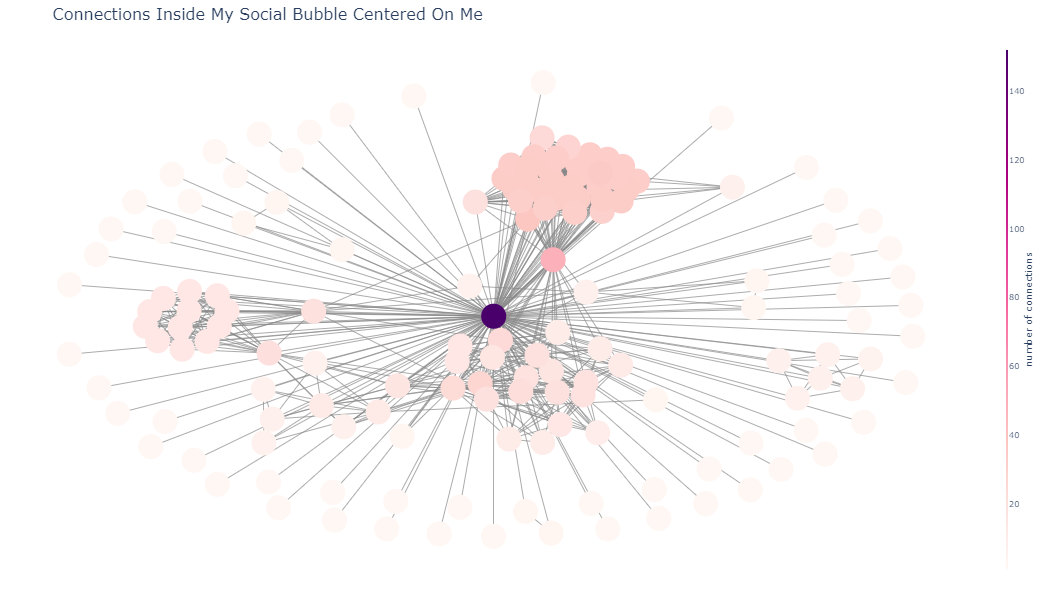

__Here are some interesting connections found from next graph:__
- Some boy from school MUN conference knows a lot of people from my english club (probably he attended both, but I just didn't remember him)
- My current fellow student is in some chats with my previous best friend from first school, my really good friend from dance club, my very important friend from first school, with my cousin
- Someone has very similar username to mine( "menenema" and "ymenenema") ((
- Three completely disconnected parts are: dance friends, teammates, english courses
- el_usya and yavrumslava are very extroverted and active
- and some more but quite personal)

In [286]:
print("")
plot_graph(privG_connected_without_me_v2, title="Connections Inside My Social Bubble", colorbar_title="number of connections", colorscale="matter")

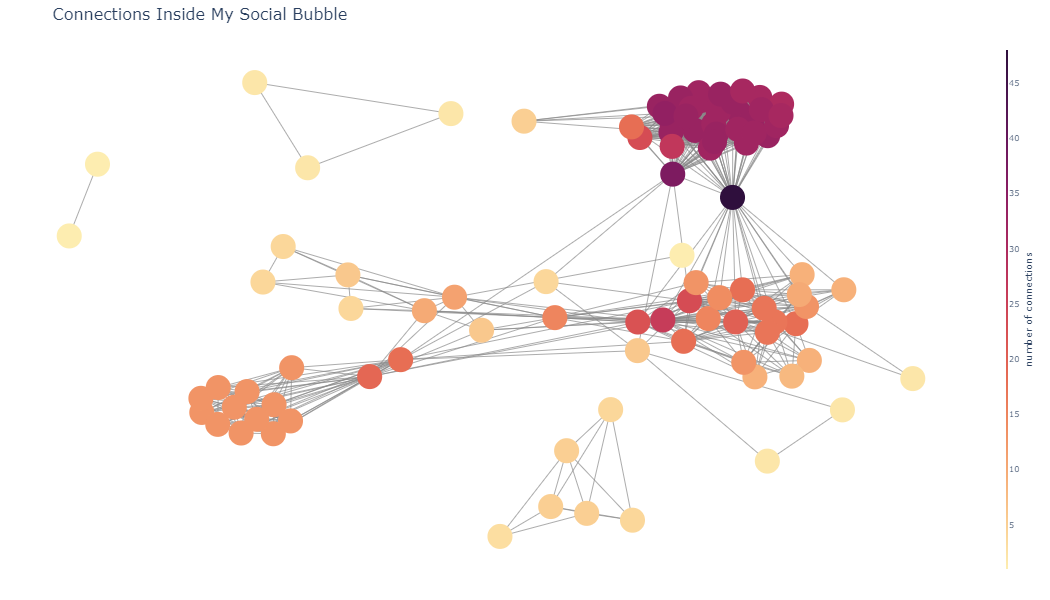